# Histograms on numerical datasets

Histogram graphs are a very handy way to visualize numerical data, compare different values of a specific field, and thus extract conclusions about the dataset. We are going to study the `diffprivlib`'s method of creating an histogram, and its accuracy when changing the epsilon factor.

The IBM DP library offers a differential private way to create histograms. The difference with the simple queries that we tested, is that now, __geometric truncated__ noise is added in order to satisfy DP.

## The identity of the dataset: Employee salaries

The dataset contains sensitive data regarding employee's salaries in the state of Baltimore, while stating other facts about the members of the dataset. 

The columns contained are: 
 - __Name__
 - __Job Title__
 - __ID__
 - __Job description__
 - __Hire date__
 - __Annual earnings__
 - __Gross earnings__

## Import libraries

In [1]:
import pandas as pd
import diffprivlib as dp
import numpy as np
import math
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
DATASET = "./salaries.csv"
df = pd.read_csv(DATASET)

Let's take a look at the dataset info to see if everything is alright.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13811 entries, 0 to 13810
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       13811 non-null  object 
 1   JOBTITLE   13811 non-null  object 
 2   DEPTID     13811 non-null  object 
 3   DESCR      13811 non-null  object 
 4   HIRE_DT    13807 non-null  object 
 5   ANNUAL_RT  13811 non-null  float64
 6   Gross      13158 non-null  float64
dtypes: float64(2), object(5)
memory usage: 755.4+ KB


In [4]:
df.head()

,NAME,JOBTITLE,DEPTID,DESCR,HIRE_DT,ANNUAL_RT,Gross
0,"Aaron,Kareem D",Utilities Inst Repair I,A50550,DPW-Water & Waste Water (550),08/27/2018 12:00:00 AM,32470.0,25743.94
1,"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev (031),10/24/1979 12:00:00 AM,60200.0,57806.13
2,"Abadir,Adam O",Council Technician,A02002,City Council (002),12/12/2016 12:00:00 AM,64823.0,64774.11
3,"Abaku,Aigbolosimuan O",Police Officer,A99094,Police Department (094),04/17/2018 12:00:00 AM,53640.0,59361.55
4,"Abbeduto,Mack",Assistant State's Attorney,A29011,States Attorneys Office (011),05/22/2017 12:00:00 AM,68562.0,61693.59


## Privacy Setup

### Target column

Throughout our tests, we are going to apply noise into 2 target columns: the __annual earnings__, and the __gross earnings__.

### Bounds definition

With our prior knowledge regarding the IBM's bounds' selection requirements, we are going to define ourselves the bounds for the DP algorithms, by guessing the possible minimum and maximum values.

In [5]:
annual_earnings_range = (0, 1000000)
annual_gross_range = (0, 1000000)

## Histograms

We are going to run various histograms, in order to observe the effect of applying DP to our dataset. 

### Accurate testings

We know by now that the noise inserted in the query by the DP algorithms is based on probabilistic distributions. Thus, it is clear that our testings will not be accurate if we run the query once, because it is possible that we get extreme values of noise, and as a result, extreme differences between the real histogram and the noisy one. 

In order to achieve that, we are going to define a function that takes as an argument the arguments of the hist function, runs the histogram query multiple times, and finally returns the mean value of all of those runs.

In [12]:
def accurate_histogram(input_list, bins, epsilon, bounds_range):
    # initialize a list of the upcoming result of the histogram
    result = [0] * (bins + 1)
    for i in range (1, 100):
        # compute the i-th histogram
        new_list = dp.tools.histogram(input_list, bins = bins, epsilon = epsilon, range = bounds_range)[0]
        # calculate a new list, by adding the previous, and the new histogram
        result = [sum(x) for x in zip(result, new_list)]
    # finally return the mean results of the 100 histograms
    return [(math.floor(a / 100)) for a in result]

### Histogram on annual earnings

We are going to study our dataset data, by creating a histogram based on the annual earnings. Let's start with a normal hist, without differential privacy.

[1313 6146 4036 1869  329   81   29    5    1    2]


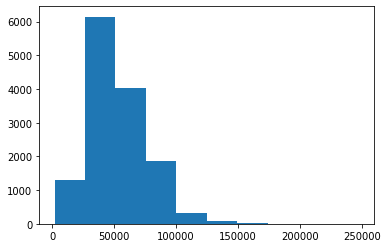

In [18]:
hist, bins = np.histogram(df['ANNUAL_RT'].tolist(), bins = 10)
plt.hist(bins[:-1], len(hist), weights = hist)

print(hist)

Let's now plot the differential private histogram regarding the same data.

[12811, 856, 4, 0, 0, 0, 0, 0, 0, 0]


(array([1.2811e+04, 8.5600e+02, 4.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([  1750. ,  26342.5,  50935. ,  75527.5, 100120. , 124712.5,
        149305. , 173897.5, 198490. , 223082.5, 247675. ]),
 <a list of 10 Patch objects>)

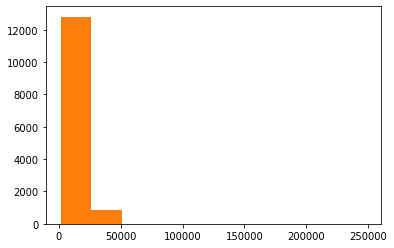

In [20]:
hist = accurate_histogram(df['ANNUAL_RT'].tolist(), 10, 1, annual_earnings_range)
plt.hist(bins[:-1], len(hist), weights = hist)

print(hist)

plt.hist(bins[:-1], len(hist), weights = hist)

The results are rather alarming. The 2 histograms are not even close when it comes down to accuracy. The most obvious reason for this result is the naive bounds that we have taken. Lets cheat a bit, and plot the histogram with the best bounds possible: the min and the max value of the column. 

/home/nikos/.local/lib/python3.8/site-packages/diffprivlib/tools/histograms.py:130: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"


(array([1.313e+03, 6.146e+03, 4.036e+03, 1.869e+03, 3.290e+02, 8.100e+01,
        2.900e+01, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([  1750. ,  26342.5,  50935. ,  75527.5, 100120. , 124712.5,
        149305. , 173897.5, 198490. , 223082.5, 247675. ]),
 <a list of 10 Patch objects>)

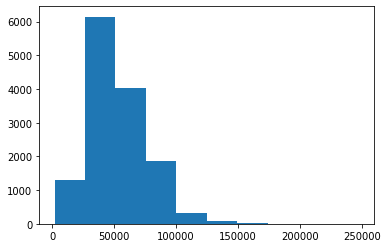

In [21]:
ideal_bounds = (min(df['ANNUAL_RT']), max(df['ANNUAL_RT']))
hist, bins = dp.tools.histogram(df['ANNUAL_RT'].tolist(), bins = 10, epsilon = 10, bounds_range = ideal_bounds)
plt.hist(bins[:-1], len(hist), weights = hist)

As we can see, the result is almost identical to the previously plotted non-DP histogram. Let's try and guess again the bounds, this time by narrowing the range, in a desperate search for better results.

(array([5.978e+03, 5.807e+03, 1.419e+03, 1.430e+02, 3.100e+01, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([  1750. ,  26342.5,  50935. ,  75527.5, 100120. , 124712.5,
        149305. , 173897.5, 198490. , 223082.5, 247675. ]),
 <a list of 10 Patch objects>)

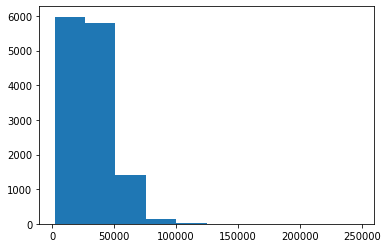

In [24]:
# no employee gets less than 1k per month, and no employee gets more than 400k a year
better_bounds = (12000, 400000)

hist = accurate_histogram(df['ANNUAL_RT'].tolist(), bins = 10, epsilon = 10, bounds_range = better_bounds)
plt.hist(bins[:-1], len(hist), weights = hist)

Once again, those are some very disappointing results. We can safely come to the conclusion that our DP visualization will be irrelevant with the non-DP one, unless we violate the principals of DP, and choose our bounds based on our dataset info.

### Default parameters

Let's now run the IBM's histogram without specifying any parameters, just the column we want to plot, as any non-DP expert would have done.

[1314 6147 4036 1869  330   83   29    5    1    1]


/home/nikos/.local/lib/python3.8/site-packages/diffprivlib/tools/histograms.py:130: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"


(array([1.314e+03, 6.147e+03, 4.036e+03, 1.869e+03, 3.300e+02, 8.300e+01,
        2.900e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([  1750. ,  26342.5,  50935. ,  75527.5, 100120. , 124712.5,
        149305. , 173897.5, 198490. , 223082.5, 247675. ]),
 <a list of 10 Patch objects>)

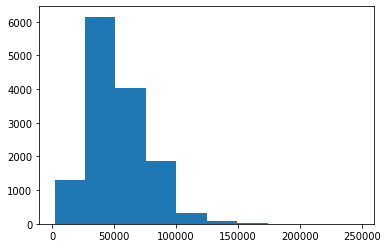

In [28]:
hist, bins = dp.tools.histogram(df['ANNUAL_RT'].tolist())
print(hist)
plt.hist(bins[:-1], len(hist), weights = hist)

The results are perfect, but the library outputs a __privacy warning__, stating: `To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).`. 

While looking at the source code of the histograms in the library, we see that that the range is defined as following:
```
    range : (float, float), optional
        The lower and upper range of the bins.  If not provided, range is simply ``(a.min(), a.max())``. 
```

This is the reason of the privacy warning. So, if an analyst would like to run a histogram with default values, the library would not guarantee any privacy at all, because of the leakage of extreme values. In our example, it is clear that exactly one person get payed more than 250k a year, something that definitely leaks information about our dataset.

## Histogram queries in theory

Based on `Dwork, C., Roth, A. (2014). The Algorithmic Foundations of Differential Privacy` the histogram queries are very high sensitivity queries, thus a slight change to the bounds could be critical for their result. 

The writers suggest that we use noise generated by the LaPlace mechanism, but with a slight change. In detail they suggest the following:


"_In the special (but common) case in which the queries are structurally disjoint we can do much better — we do not necessarily have to let the noise scale with the number of queries. An example is the histogram query. In this type of query the universe $N^X$ is partitioned into cells, and the query asks how many database elements lie in each of the cells. Because the cells are disjoint, the addition or removal of a single database element can affect the count in exactly one cell, and the difference to that cell is bounded by 1, so histogram queries have sensitivity 1 and can be answered by adding independent draws from $Lap(\frac{1}{\epsilon})$ to the true count in each cell._"

It is clear that the IBM library does not follow this suggestion, which results in very bad results in the histogram query.

## Conclusions

After plotting a very basic histogram using `diffprivlib`'s functions, it is clear that the histograms created can not be trusted. The only way that they are going to be accurate, is if we define the bounds (and thus the sensitivity of the database), as the tuple of min and max values in the column that we are interested in. 

This, as we've stated earlier, violates the foundations of differential privacy. The bounds must be defined without any prior knowledge of the dataset, and more importantly, they must not be real values presented on it. 